![alt text](http://s3.otherpeoplespixels.com/sites/13962/assets/GVfogqiU3fRwW40q.jpg)

# Locating Gentrification at the Community District Level Using Streetscores
The purpose of this project is to identify areas of the city that are likely in the process of gentrification. We decided to work at the Community District level to include datasets that operated at this scale and to compare our results with the [Furman Center](http://furmancenter.org/files/sotc/Part_1_Gentrification_SOCin2015_9JUNE2016.pdf), which also worked at the Community District level. To measure gentrification, we used the MIT [Streetscore](http://streetscore.media.mit.edu/about.html), a machine learning algorithm that examines the Google Streetview of each parcel of land and predicts how safe the image looks to a human observer: 

![Alt Text](http://streetscore.media.mit.edu/static/img/streetscore_dynamic_15s.gif)

Since the Streetscores for NYC were only calculated once in 2015, we used machine learning to generate our own algorithm that would predict the Streetscore based on data from 2015. We then applied the algorithm to data from 2010-2014 to get a timeseries of the Streetscore. Areas with the largest percent change during this period were identified as potentially gentrifying.

In [1]:
# To run this notebook, you need to create a virtual environment and install the necessary packages. Please read the "READ_ME" 
# document before running. 

import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import pysal as ps
from shapely.geometry import Point, LineString, Polygon
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import statsmodels.api as sm
from __future__ import division 
import sklearn
import seaborn as sns
from sklearn import metrics, svm
from sklearn.metrics import precision_recall_curve,roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              AdaBoostClassifier)
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%pylab inline

/nfshome/rmb623/.conda/envs/myVE/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


# Independent Variable: StreetScore

The first step is calculating the average Streetscore for each Community District. The [Streetscore dataset](http://streetscore.media.mit.edu/data.html) is a csv file with the score and geolocation of every Google Streetview in the city. Thus, we need to convert the csv file to a shapefile, merge the Streetscores with a [shapefile of community districts](https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page), and aggregate the data by Community District to get the average score. 

In [2]:
# The CSV file was converted to a shapefile using QGIS, an open-source GIS software 
# Reading Streetscores into geopandas and filtering out scores less than zero (invalid entries)
streetscores = gpd.read_file('/projects/ada_pub_3/shared/Dani/data/streetscore/streetscore.shp')
streetscores = streetscores[streetscores['q-score']>0]
streetscores.head()

,latitude,longitude,q-score,geometry
0,40.700909,-74.013504,11.062166,POINT (-74.013504 40.700909)
1,40.701000,-74.013878,10.818611,POINT (-74.01387800000001 40.701)
2,40.701080,-74.012878,12.677955,POINT (-74.012878 40.70108)
3,40.701187,-74.013268,11.417325,POINT (-74.013268 40.701187)
4,40.701244,-74.012115,25.199091,POINT (-74.01211499999999 40.701244)


In [3]:
# Reading Community District shapefule into geopandas and reprojected to match the projection of the Streetscores
cd = gpd.read_file('/projects/ada_pub_3/shared/Dani/data/cd/nycd.shp')
cd = cd.to_crs({'init': 'epsg:4326'})
cd.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,311,51549.557886,1.031778e+08,POLYGON ((-73.97299433938895 40.60881414183557...
1,313,65821.999543,8.819584e+07,"POLYGON ((-73.98372152615245 40.5958210782504,..."
2,312,52245.830489,9.952550e+07,"POLYGON ((-73.97139631688151 40.6482577861474,..."
3,304,37008.100320,5.666322e+07,POLYGON ((-73.89646625062903 40.68233642250863...
4,209,62239.832144,1.142663e+08,POLYGON ((-73.83979488495993 40.83561920752522...


In [4]:
# Merging Streetscores with Community Districts to determine which scores are in which districts
score_in_cd = gpd.sjoin(streetscores, cd, how='inner', op='intersects')
score_in_cd = score_in_cd[['q-score','BoroCD']]
score_in_cd.columns = ['streetscore','cd']
score_in_cd.head()

,streetscore,cd
0,11.062166,101
1,10.818611,101
2,12.677955,101
3,11.417325,101
4,25.199091,101


In [5]:
# Finding the mean Streetscore of each Community District through aggregation
cd_score = score_in_cd.groupby(['cd'])['streetscore'].mean()
cd_score = pd.DataFrame(cd_score)
cd_score = cd_score.reset_index(drop=False)
cd_score.head()

,cd,streetscore
0,101,24.300524
1,102,25.739928
2,103,25.950510
3,104,24.330774
4,105,25.753933


# Dependent Variables

Now that we have the average Streetscore for each Community District, we need to read in and clean various datasets so that we have input values for 2010-2015 at the Community District scale. Very few datasets are aggregated at the Community District level, so we need to match whatever level each dataset is recorded at with the appropriate Community District.

### Percent White and Adjusted Median Income
*Source: American Community Survey data provided by the Furman Center*

This dataset is already aggregated at the Community District level, so we just need to slice out the information we want.

In [6]:
# Reading in csv of ACS data
acs = pd.read_csv('/projects/ada_pub_3/shared/Dani/data/acs/acs_all.csv')
acs.head()

,geoid,fc_geoid,fc_geo_type,fc_id_display,fc_geo_name,endyear,pop_race_asian_num,pop_race_black_num,pop_race_hisp_num,pop_race_white_num,...,pop_race_black_pct,pop_race_hisp_pct,pop_race_white_pct,pop_race_div_idx,hh_inc_med,rent_gross_med,rent_contract_med,hh_inc_med_adj,rent_gross_med_adj,rent_contract_med_adj
0,3603810,101,sba,MN 01,Greenwich Village/Financial District,2006,28294.0,4042.0,7260.0,105271.0,...,0.027460,0.049321,0.715166,0.448404,94871,1758.0,1691.0,115427.099773,2138.913276,2057.396103
1,3603810,101,sba,MN 01,Greenwich Village/Financial District,2008,21743.0,3150.0,7968.0,116656.0,...,0.020638,0.052204,0.764291,0.392416,105712,1949.0,1876.0,120389.962932,2219.615916,2136.479969
2,3603810,101,sba,MN 01,Greenwich Village/Financial District,2009,21019.0,2569.0,8024.0,103191.0,...,0.018333,0.057260,0.736379,0.431633,101794,NaN,1965.0,115417.396305,NaN,2227.981843
3,3603810,101,sba,MN 01,Greenwich Village/Financial District,2010,21142.0,3420.0,8114.0,106063.0,...,0.023595,0.055980,0.731752,0.439573,102119,NaN,NaN,113844.301681,NaN,NaN
4,3603810,101,sba,MN 01,Greenwich Village/Financial District,2011,17266.0,2646.0,9871.0,110516.0,...,0.018063,0.067383,0.754422,0.412089,119866,NaN,NaN,129931.689744,NaN,NaN


In [7]:
# Slicing the Community District, percent of population that is white, and adjusted median income for 2010
acs_2010 = acs[acs['endyear']==2010]
acs_2010 = acs_2010[['fc_geoid','pop_race_white_pct','hh_inc_med_adj']]
acs_2010.columns = ['cd','per_white','med_income']

acs_2010.head()

,cd,per_white,med_income
3,101,0.731752,113844.301681
13,102,0.337371,47172.492693
23,103,0.636048,86783.161452
33,104,0.692555,101582.396705
43,105,0.680960,100334.913146


In [8]:
# Slicing the Community District, percent of population that is white, and adjusted median income for 2011
acs_2011 = acs[acs['endyear']==2011]
acs_2011 = acs_2011[['fc_geoid','pop_race_white_pct','hh_inc_med_adj']]
acs_2011.columns = ['cd','per_white','med_income']

acs_2011.head()

,cd,per_white,med_income
4,101,0.754422,129931.689744
14,102,0.302985,42450.610129
24,103,0.637060,90002.404347
34,104,0.748777,110075.444497
44,105,0.690630,99899.091709


In [9]:
# Slicing the Community District, percent of population that is white, and adjusted median income for 2012
acs_2012 = acs[acs['endyear']==2012]
acs_2012 = acs_2012[['fc_geoid','pop_race_white_pct','hh_inc_med_adj']]
acs_2012.columns = ['cd','per_white','med_income']

acs_2012.head()

,cd,per_white,med_income
5,101,0.697482,109362.782397
15,102,0.330159,43401.101873
25,103,0.661957,91717.862765
35,104,0.731037,98260.026605
45,105,0.693153,97609.424676


In [10]:
# Slicing the Community District, percent of population that is white, and adjusted median income for 2013
acs_2013 = acs[acs['endyear']==2013]
acs_2013 = acs_2013[['fc_geoid','pop_race_white_pct','hh_inc_med_adj']]
acs_2013.columns = ['cd','per_white','med_income']

acs_2013.head()

,cd,per_white,med_income
6,101,0.703647,131013.186467
16,102,0.300592,41959.223153
26,103,0.608105,105214.322926
36,104,0.691247,112994.965756
46,105,0.686875,103790.346100


In [11]:
# Slicing the Community District, percent of population that is white, and adjusted median income for 2014
acs_2014 = acs[acs['endyear']==2014]
acs_2014 = acs_2014[['fc_geoid','pop_race_white_pct','hh_inc_med_adj']]
acs_2014.columns = ['cd','per_white','med_income']

acs_2014.head()

,cd,per_white,med_income
7,101,0.717741,124018.824886
17,102,0.356457,42683.773277
27,103,0.601712,101700.802060
37,104,0.695596,108989.835914
47,105,0.675003,109563.548092


In [12]:
# Slicing the Community District, percent of population that is white, and adjusted median income for 2015
acs_2015 = acs[acs['endyear']==2015]
acs_2015 = acs_2015[['fc_geoid','pop_race_white_pct','hh_inc_med_adj']]
acs_2015.columns = ['cd','per_white','med_income']

acs_2015.head()

,cd,per_white,med_income
8,101,0.693403,125884.659231
18,102,0.331019,43559.604234
28,103,0.594345,105401.298444
38,104,0.701078,110117.129545
48,105,0.662682,104126.498822


### Average Property Tax Exemptions Per Lot
*Source: [NYC Department of Finance](http://www1.nyc.gov/site/finance/taxes/property-assessments.page)*

This dataset contains the property tax exemption for every BBL in the city. However, it contains columns that can be converted into Community District. Each Borough is assigned a number between 1-5 and each Community District is assigned a number from 1-18. Community District numbers repeat in each Borough such that there is a Community District 1 in all five Boroughs. When working at the city level, Community Districts are assigned a three digit got comprised of the Borough code plus the Community District Code. Thus, 101 is Comminity District 1 in Manhattan, 201 is Community District 1 in Brooklyn, etc. This dataset has the Borough number in one column and the Community District number in another allowing for a calculation of the city-wide Community District number.

In [13]:
# Reading in tax data files for all years
filenames = ['/projects/ada_pub_3/shared/Dani/data/tax/tax_2010.csv',
             '/projects/ada_pub_3/shared/Dani/data/tax/tax_2011.csv',
             '/projects/ada_pub_3/shared/Dani/data/tax/tax_2012.csv',
             '/projects/ada_pub_3/shared/Dani/data/tax/tax_2013.csv',
             '/projects/ada_pub_3/shared/Dani/data/tax/tax_2014.csv',
             '/projects/ada_pub_3/shared/Dani/data/tax/tax_2015.csv']

taxes = []
for filename in filenames:
    taxes.append(pd.read_csv(filename))

taxes[0].head()

,BBLE,FN_EXT,CP_BORO,CP_DIST
0,1000010010,113373000,1.0,1.0
1,1000010101,8082000,1.0,1.0
2,1000010201,77828400,1.0,1.0
3,1000020001,37372770,1.0,1.0
4,1000020023,14769000,1.0,1.0


In [14]:
# Defining a function to calculate the Community District number and average tax exemption per lot

def get_tax_cd(df):
    """
    This part of the function calculates the Community District number by multiplying the Borough number (1-5) by 100 
    (100-500) and adding the Community District number and removing the decimal
    
    """
    cd = df['CP_BORO'] * 100 + df['CP_DIST']
    df['cd'] = cd.astype(str).str[0:3]
    
    """
    This part of the function finds the average tax exemption (FN_EXT) per lot for each Community District
    
    """
    
    df = df.groupby('cd')['FN_EXT'].mean().reset_index(drop=False)
    df['cd'] = df['cd'].astype(float)
    df = df.dropna(axis=0, how='any')
    df['cd'] = df['cd'].astype(int)
    df.columns = ['cd','tax_exempt']
    return df

In [15]:
# Slicing tax data for 2010 and running the function
tax_2010 = taxes[0]
tax_2010 = get_tax_cd(tax_2010)
tax_2010.head()

,cd,tax_exempt
0,101,399513.829215
1,102,185489.286360
2,103,276558.771122
3,104,232696.094978
4,105,422278.849133


In [16]:
# Slicing tax data for 2011 and running the function
tax_2011 = taxes[1]
tax_2011 = get_tax_cd(tax_2011)
tax_2011.head()

,cd,tax_exempt
0,101,420764.831352
1,102,181754.960885
2,103,290776.361160
3,104,246775.019369
4,105,423197.763889


In [17]:
# Slicing tax data for 2012 and running the function
tax_2012 = taxes[2]
tax_2012 = get_tax_cd(tax_2012)
tax_2012.head()

,cd,tax_exempt
0,101,424014.924979
1,102,183417.938054
2,103,290132.817424
3,104,251692.108100
4,105,428174.987283


In [18]:
# Slicing tax data for 2013 and running the function
tax_2013 = taxes[3]
tax_2013 = get_tax_cd(tax_2013)
tax_2013.head()

,cd,tax_exempt
0,101,448668.040371
1,102,185361.652741
2,103,290689.855698
3,104,270845.875525
4,105,421306.441788


In [19]:
# Slicing tax data for 2014 and running the function
tax_2014 = taxes[4]
tax_2014 = get_tax_cd(tax_2014)
tax_2014.head()

,cd,tax_exempt
0,101,462275.524957
1,102,184791.374701
2,103,301278.077670
3,104,275947.683461
4,105,416556.397224


In [20]:
# Slicing tax data for 2015 and running the function
tax_2015 = taxes[5]
tax_2015 = get_tax_cd(tax_2015)
tax_2015.head()

,cd,tax_exempt
0,101,477574.780242
1,102,196425.438938
2,103,320417.444318
3,104,295829.447172
4,105,417041.373029


### Percent Jobs Held By White People
*Source: [LEHD Origin-Destination Employment Statistics (LODES)](https://lehd.ces.census.gov/data/#lodes)*

This dataset contains data on each tax lot. In order to determine which Community District each lot is in, we need to use the Census geolocation code: 

![Alt text](http://proximityone.com/cv_dr_graphics/geo_block.jpg)

To convert this code to Community District, we need to merge it with a key from the Census that lists each tax lot with its Community District. To merge the datasets, though, we need to combine columns in the Census key so that it matches the code of the LODES data.  

In [21]:
# Reading in employment data files for all years
filenames = ['/projects/ada_pub_3/shared/Dani/data/lodes/lodes_2010.csv',
             '/projects/ada_pub_3/shared/Dani/data/lodes/lodes_2011.csv',
             '/projects/ada_pub_3/shared/Dani/data/lodes/lodes_2012.csv',
             '/projects/ada_pub_3/shared/Dani/data/lodes/lodes_2013.csv',
             '/projects/ada_pub_3/shared/Dani/data/lodes/lodes_2014.csv',
             '/projects/ada_pub_3/shared/Dani/data/lodes/lodes_2015.csv']

jobs = []
for filename in filenames:
    jobs.append(pd.read_csv(filename, usecols=['w_geocode','C000','CR01']))
    
jobs[0].head()

,w_geocode,C000,CR01
0,360010001001005,99,96
1,360010001001008,504,458
2,360010001001009,3,0
3,360010001001010,13,12
4,360010001001018,2,2


In [22]:
# Reading in census data to merge census parcel with Community District
census_cd = pd.read_csv('/projects/ada_pub_3/shared/Dani/data/cd/census_cd.csv',dtype=str)
census_cd['location'] = census_cd['2010 Census Bureau FIPS County Code'] + census_cd['2010 Census Tract']
census_cd.head()

,2010 Census Bureau FIPS County Code,2010 Census Tract,CD,location
0,005,031000,211,005031000
1,005,031200,211,005031200
2,005,031400,211,005031400
3,005,031600,211,005031600
4,005,031800,211,005031800


In [23]:
# Defining a function to calculate the Community District mean of each census tract

def get_job_cd(df):
    """
    This part of the fuction is first aggregating total jobs and total white jobs for each tract 
    Then, it is merging with the Census key by cutting the state and block
    
    """
    
    df.columns = ['location','total_jobs', 'white_jobs']
    df['location'] = df['location'].astype(str).str[2:11]
    df = df.groupby('location')[['total_jobs','white_jobs']].sum().reset_index()
    df = df.merge(census_cd)
    
    """
    This part of the function is first aggregating total jobs and total white jobs by Community District 
    Then, it is dividng total jobs by total white jobs to find the proportion of jobs held by white people
    
    """
    
    df = df.groupby('CD')[['total_jobs','white_jobs']].sum().reset_index()
    df['per_wj'] = df['white_jobs'] / df["total_jobs"]
    df = df[['CD','per_wj']] 
    df['CD'] = df['CD'].astype(int)
    return df

In [24]:
# Slicing job data for 2010 and running the function
lodes_2010 = jobs[0]
lodes_2010 = get_job_cd(lodes_2010)
lodes_2010.head()

,CD,per_wj
0,101,0.644286
1,103,0.545880
2,104,0.687037
3,106,0.686728
4,107,0.657737


In [25]:
# Slicing job data for 2011 and running the function
lodes_2011 = jobs[1]
lodes_2011 = get_job_cd(lodes_2011)
lodes_2011.head()

,CD,per_wj
0,101,0.646760
1,103,0.556738
2,104,0.687542
3,106,0.686843
4,107,0.665503


In [26]:
# Slicing job data for 2012 and running the function
lodes_2012 = jobs[2]
lodes_2012 = get_job_cd(lodes_2012)
lodes_2012.head()

,CD,per_wj
0,101,0.652696
1,103,0.567373
2,104,0.691117
3,106,0.691068
4,107,0.667870


In [27]:
# Slicing job data for 2013 and running the function
lodes_2013 = jobs[3]
lodes_2013 = get_job_cd(lodes_2013)
lodes_2013.head()

,CD,per_wj
0,101,0.656580
1,103,0.575590
2,104,0.692847
3,106,0.689790
4,107,0.670206


In [28]:
# Slicing job data for 2014 and running the function
lodes_2014 = jobs[4]
lodes_2014 = get_job_cd(lodes_2014)
lodes_2014.head()

,CD,per_wj
0,101,0.657310
1,103,0.575708
2,104,0.696268
3,106,0.687118
4,107,0.668984


In [29]:
# Slicing job data for 2015 and running the function
lodes_2015 = jobs[5]
lodes_2015 = get_job_cd(lodes_2015)
lodes_2015.head()

,CD,per_wj
0,101,0.660341
1,103,0.564671
2,104,0.699690
3,106,0.689665
4,107,0.678233


### 311 Data

*Source: [NYC Open Data](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9)*

Data from 311 calls list every complaint filed and geolocates it using latitude and longitude. Just like the Streetscores above, these points need to be converted to a shapefile and merged with the Community District shapefile. Aggregation for this dataset was simply a count of the calls made within each Community District in a given year. To avoid overly-weighting this metric, we decided to focus on only noise complaints.

In [30]:
# Reading in 311 data for all years
filenames = ['/projects/ada_pub_3/shared/Dani/data/311/311_2010.csv',
             '/projects/ada_pub_3/shared/Dani/data/311/311_2011.csv',
             '/projects/ada_pub_3/shared/Dani/data/311/311_2012.csv',
             '/projects/ada_pub_3/shared/Dani/data/311/311_2013.csv',
             '/projects/ada_pub_3/shared/Dani/data/311/311_2014.csv',
             '/projects/ada_pub_3/shared/Dani/data/311/311_2015.csv']

d_311 = []

for filename in filenames:
    d_311.append(pd.read_csv(filename, usecols=['Complaint Type','Latitude','Longitude','Location']))
    
d_311[0].head()

,Complaint Type,Latitude,Longitude,Location
0,Noise,40.818858,-73.867230,"(40.818857890625004, -73.86722973414106)"
1,Sewer,40.808229,-73.855070,"(40.8082293975806, -73.85507018978365)"
2,Hazardous Materials,40.882940,-73.848275,"(40.88293989911719, -73.84827488251594)"
3,Dirty Conditions,40.808697,-73.945573,"(40.808697398492676, -73.94557284342076)"
4,Water System,40.757346,-73.735249,"(40.75734572888292, -73.7352494295963)"


In [31]:
# Defining a function to count the noise complaints within each Community District for a given year 

def get_noise_cd(df):
    """
    This part of the function is first slicing out the noise complaints and latitude/longitude of the call
    Then, it uses geopandas to convert the dataframe into a geodataframe
    
    """
    df = df[df['Complaint Type']=='Noise']
    df = df[['Latitude','Longitude']].astype(float).dropna(axis=0, how='any')
    geometry = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    df = df.drop(['Longitude', 'Latitude'], axis=1)
    crs = {'init': 'epsg:4326'}
    gdf = GeoDataFrame(df, crs=crs, geometry=geometry)
    
    """
    This part of the function first merges the geodataframe with the Community District shapefile as we did above
    Then, it counts the number of calls per Community District
    
    """
    gdf['count'] = 1
    gdf = gpd.sjoin(gdf, cd, how='inner')
    gdf = gdf[['count', 'BoroCD']]
    gdf.columns = ['count', 'cd']
    gdf = gdf.groupby('cd')['count'].sum().reset_index(drop=False)
    return gdf

In [32]:
# Slicing noise data for 2010 and running the function
noise_2010 = d_311[0]
noise_2010 = get_noise_cd(noise_2010)
noise_2010.head()

,cd,count
0,101,1168
1,102,1386
2,103,1117
3,104,1320
4,105,1142


In [33]:
# Slicing noise data for 2011 and running the function
noise_2011 = d_311[1]
noise_2011 = get_noise_cd(noise_2011)
noise_2011.head()

,cd,count
0,101,112
1,102,78
2,103,54
3,104,99
4,105,85


In [34]:
# Slicing noise data for 2012 and running the function
noise_2012 = d_311[2]
noise_2012 = get_noise_cd(noise_2012)
noise_2012.head()

,cd,count
0,101,1887
1,102,1514
2,103,1443
3,104,1602
4,105,1765


In [35]:
# Slicing noise data for 2013 and running the function
noise_2013 = d_311[3]
noise_2013 = get_noise_cd(noise_2013)
noise_2013.head()

,cd,count
0,101,2198
1,102,2131
2,103,1662
3,104,1959
4,105,2345


In [36]:
# Slicing noise data for 2014 and running the function
noise_2014 = d_311[4]
noise_2014 = get_noise_cd(noise_2014)
noise_2014.head()

,cd,count
0,101,2681
1,102,2511
2,103,2256
3,104,3192
4,105,2910


In [37]:
# Slicing noise data for 2015 and running the function
noise_2015 = d_311[5]
noise_2015 = get_noise_cd(noise_2015)
noise_2015.head()

,cd,count
0,101,2475
1,102,2477
2,103,2301
3,104,3149
4,105,3206


# Modeling Streetscore

Now that we have our dependent variable (the Streetscore) and a number of independent variables (percent of population that is white, adjusted median income, percent jobs held by white people, mean tax exemption per lot, and number of noise complaints), we can create our model algorithm to predict the 2015 Streetscore.

### Modeling with StatsModels

This package works a lot like statistical software programs (e.g. R, Stata, SPSS, SAS, etc.) that generate basic multivariate linear regression. We start with this simplistic modeling to have a comparison for the machine learning modeling that follows. 

In [38]:
# First, we need to make a dataset for 2015 combining all variables
model_2015 = cd_score.merge(acs_2015, left_on='cd', right_on='cd')
model_2015 = model_2015.merge(lodes_2015, left_on='cd',right_on='CD')
model_2015 = model_2015.merge(tax_2015, left_on='cd', right_on='cd')
model_2015 = model_2015.merge(noise_2015, left_on='cd', right_on='cd')
model_2015 = model_2015[['cd','streetscore','per_white','med_income','per_wj','tax_exempt','count']]
model_2015.columns = ['community district','street score','% white','med income', 
                  '% jobs white','mean tax exemption','# noise complaints']
model_2015 = model_2015.dropna(axis=0, how='any')
model_2015.head()

,community district,street score,% white,med income,% jobs white,mean tax exemption,# noise complaints
0,101,24.300524,0.693403,125884.659231,0.660341,477574.780242,2475
1,103,25.950510,0.594345,105401.298444,0.564671,320417.444318,2301
2,104,24.330774,0.701078,110117.129545,0.699690,295829.447172,3149
3,106,25.436474,0.751397,105583.707121,0.689665,230741.144391,2528
4,107,27.451074,0.307653,50170.630570,0.678233,148122.819702,2518


In [39]:
# Fitting a linear regression model
X = model_2015[['% white','med income','% jobs white','mean tax exemption','# noise complaints']]
Y = model_2015['street score']
X = sm.add_constant(X)

streetscore_model = sm.OLS(Y, X)
streetscore_model = streetscore_model.fit()
streetscore_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           street score   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.068
Date:                Tue, 24 Apr 2018   Prob (F-statistic):              0.391
Time:                        11:52:07   Log-Likelihood:                -76.197
No. Observations:                  49   AIC:                             164.4
Df Residuals:                      43   BIC:                             175.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 28.5120      2.060     13.839      0.000      24.357      32.667
% white                1.9853      1.535      1.293      0.203      -1.110       5.081
med income         -2.137e-05   1.33e-05     -1.612      0.114   -4.81e-05    5.36e-06
% jobs white          -5.1541      3.464     -1.488      0.144     -12.141       1.832
mean tax exemption  2.568e-07      4e-07      0.642      0.524    -5.5e-07    1.06e-06
# noise complaints     0.0004      0.000      1.937      0.059   -1.84e-05       0.001
==============================================================================
Omnibus:                        1.795   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.280
Skew:                          -0.394   Prob(JB):                        0.527
Kurtosis:                       3.069   Cond. No.                     1.47e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This model produced an output that is similar to a basic statistics program. We will use the coefficients and intercept below to estimate the Streetscores for 2010-2014. But first, we want to stretch beyond our knowledge of basic statistical programs and experiment with machine learning.

### Scikit Machine Learning

This package uses machine learning to create a model based on a training dataset which is then applied to a test dataset to measure the accuracy. 

In [40]:
# Splitting data into test and train
train, test = train_test_split(model_2015, test_size=0.5)

Before starting the modeling, it is important to check the random division into train and test to make sure that they are not significantly different. The values will change every time the model is run, so it is worth the check. 

In [41]:
train.describe()

,community district,street score,% white,med income,% jobs white,mean tax exemption,# noise complaints
count,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000
mean,295.541667,25.520536,0.331422,57690.265098,0.609115,4.237228e+05,1048.291667
std,115.493640,1.309969,0.217071,19898.896326,0.073500,6.954449e+05,1019.297434
min,103.000000,22.404603,0.021613,25153.847358,0.470016,8.664787e+04,139.000000
25%,276.750000,24.680985,0.199489,46065.662424,0.559156,1.558400e+05,436.250000
50%,310.500000,25.611382,0.255006,50672.512070,0.619269,1.957716e+05,722.500000
75%,401.250000,26.563305,0.470458,69826.453688,0.656336,4.015998e+05,1200.000000
max,503.000000,27.451074,0.861053,105401.298444,0.771904,3.524652e+06,4707.000000


In [42]:
test.describe()

,community district,street score,% white,med income,% jobs white,mean tax exemption,# noise complaints
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,307.000000,24.990116,0.299884,60555.558455,0.603241,286078.704392,776.840000
std,119.317504,1.106937,0.261856,27500.500267,0.075665,213976.154603,805.181329
min,101.000000,22.086700,0.011063,24920.941364,0.468689,50487.518383,134.000000
25%,207.000000,24.305594,0.056070,45071.432080,0.549343,124676.731694,302.000000
50%,311.000000,24.871932,0.236255,53933.195987,0.594841,208876.683884,511.000000
75%,406.000000,25.810336,0.530881,66345.230467,0.661071,409349.299537,788.000000
max,502.000000,26.990069,0.751397,125884.659231,0.729212,906691.821464,3149.000000


In [43]:
# Selecting features and labels (the same variables as our standard regression model) 
features = ['% white','med income','% jobs white', 'mean tax exemption', '# noise complaints']
label = 'street score' 

In [44]:
# Setting up the standard model variable labels
X_train = train[features].values
y_train = train[label].values
X_test = test[features].values
y_test = test[label].values

In [45]:
# We had some issues running our model the first time, so we made sure all packages were loaded


In [46]:
# Selecting a linear regression model and fitting it to the training dataset
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
# Examining the coefficients of the model
model.coef_

array([ 2.72568248e+00, -2.40161239e-05, -5.77283556e+00,  4.08165741e-07,
        5.17699057e-04])

In [48]:
# Examining the intercept of the model
model.intercept_

28.803350760465825

In [49]:
# Applying the model to the test data
predicted = model.predict(X_test)
predicted

array([25.33428086, 25.16968637, 25.07724333, 25.84456401, 24.79003095,
       25.25730922, 25.58639342, 25.41993334, 25.28935348, 25.01406001,
       24.96773724, 25.13091978, 25.73730878, 25.03062175, 24.6186637 ,
       25.7151569 , 24.72421376, 25.16916104, 24.8662831 , 24.71234087,
       25.78146808, 24.93616964, 25.11585398, 25.46708186, 25.31797224])

In [50]:
# We know the actual values of the test data
actual = y_test
actual

array([24.30052433, 26.14082444, 23.95796999, 26.42813031, 26.18915361,
       24.69750854, 24.9243736 , 24.85848534, 24.61451527, 24.30559418,
       24.14899409, 24.87193205, 25.43647413, 24.35099069, 23.96124221,
       25.25409253, 26.28487822, 26.99006858, 25.81033595, 23.39470907,
       24.33077419, 25.64655326, 26.0770968 , 22.08670016, 25.69099092])

In [51]:
# Zippling actual and predicted into a dataframe
labels = ['actual','predicted']
cols = [actual, predicted]
zipped = list(zip(labels,cols))
data = dict(zipped)
test_model = pd.DataFrame(data)
test_model.head()

,actual,predicted
0,24.300524,25.334281
1,26.140824,25.169686
2,23.957970,25.077243
3,26.428130,25.844564
4,26.189154,24.790031


In [52]:
# Calculating the percent error of each value
test_model['error'] = ((test_model['predicted'] - test_model['actual'])/test_model['actual']) * 100
test_model.head()

,actual,predicted,error
0,24.300524,25.334281,4.254050
1,26.140824,25.169686,-3.715025
2,23.957970,25.077243,4.671820
3,26.428130,25.844564,-2.208126
4,26.189154,24.790031,-5.342374


In [53]:
# Calculating the mean percent error of all valyes
test_model['error'].mean()

1.044908927571696

In [54]:
# Measuring additional metrics
print("Mean squared error: %.2f" % mean_squared_error(actual, predicted))
print('Variance score: %.2f' % r2_score(actual, predicted))

Mean squared error: 1.32
Variance score: -0.12


In [55]:
# Measuring significance
params = np.append(model.intercept_,model.coef_)
newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
MSE = (sum((actual-predicted)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

stats = pd.DataFrame()
stats["Coefficients"],stats["Standard Errors"],stats["t values"],stats["Probabilites"] = [params,sd_b,ts_b,p_values]

stats

,Coefficients,Standard Errors,t values,Probabilites
0,28.8034,3.794,7.591,0.000
1,2.7257,3.241,0.841,0.409
2,-0.0000,0.000,-0.959,0.347
3,-5.7728,6.744,-0.856,0.400
4,0.0000,0.000,0.279,0.782
5,0.0005,0.001,0.782,0.442


# Predicting Streetscores for 2010-2014
Using model algorithms generated using the 2015 data, we now can enter data from 2010-2014 into the model to estimate what the Streetscores would have been. In effect, we are "predicting" the past, but the model should also be able to predict the future with expected values for each of the parameters.

### Using the StatsModels Model

In [56]:
# Defining a function based on the model outputs 

constant = 28.5120
x_race = 1.9853
x_income = -2.137e-05 
x_per_wj = -5.1541
x_tax = 2.568e-07
x_noise = 0.0004

def stats_est_streetscore(acs, lodes, tax, noise):
    
    """
    The function first creates a compiled dataset for all of the variables for the given year
    
    """
    
    df = acs.merge(lodes, left_on='cd',right_on='CD')
    df = df.merge(tax, left_on='cd', right_on='cd')
    df = df.merge(noise, left_on='cd', right_on='cd')
    df = df[['cd','per_white','med_income','per_wj','tax_exempt','count']]
    df = df.dropna(axis=0, how='any')
    
    """
    It then applies the parameters from the model to calculate the expected Streetscore
    
    """
    
    df['est street score']= constant + (df['per_white'] * x_race) + (df['med_income'] * x_income) + (df['per_wj'] * x_per_wj) + (df['tax_exempt'] * x_tax) + (df['count'] * x_noise)
    df = df[['cd','est street score']]
    return df

In [57]:
# Predicting the Streetscores for 2010
stats_est_2010 = stats_est_streetscore(acs_2010, lodes_2010, tax_2010, noise_2010)
stats_est_2010.head()

,cd,est street score
0,101,24.780975
1,103,25.624490
2,104,24.762811
3,106,24.967422
4,107,25.473603


In [58]:
# Predicting the Streetscores for 2011
stats_est_2011 = stats_est_streetscore(acs_2011, lodes_2011, tax_2011, noise_2011)
stats_est_2011.head()

,cd,est street score
0,101,24.052500
1,103,25.080192
2,104,24.205548
3,106,24.226672
4,107,24.764736


In [59]:
# Predicting the Streetscores for 2012
stats_est_2012 = stats_est_streetscore(acs_2012, lodes_2012, tax_2012, noise_2012)
stats_est_2012.head()

,cd,est street score
0,101,25.059253
1,103,25.593582
2,104,25.006861
3,106,24.910320
4,107,25.516433


In [60]:
# Predicting the Streetscores for 2013
stats_est_2013 = stats_est_streetscore(acs_2013, lodes_2013, tax_2013, noise_2013)
stats_est_2013.head()

,cd,est street score
0,101,24.719538
1,103,25.243640
2,104,24.751783
3,106,24.908095
4,107,25.547671


In [61]:
# Predicting the Streetscores for 2014
stats_est_2014 = stats_est_streetscore(acs_2014, lodes_2014, tax_2014, noise_2014)
stats_est_2014.head()

,cd,est street score
0,101,25.089921
1,103,25.545742
2,104,25.322885
3,106,25.152914
4,107,25.739310


In [62]:
# Predicting the Streetscores for 2015
stats_est_2015 = stats_est_streetscore(acs_2015, lodes_2015, tax_2015, noise_2015)
stats_est_2015.head()

,cd,est street score
0,101,24.907636
1,103,25.531841
2,104,25.279945
3,106,25.263275
4,107,25.600194


In [63]:
# Merging all years to create one timeseries
stats_est = stats_est_2010.merge(stats_est_2011, left_on='cd', right_on='cd')
stats_est = stats_est.merge(stats_est_2012, left_on='cd', right_on='cd')
stats_est = stats_est.merge(stats_est_2013, left_on='cd', right_on='cd')
stats_est = stats_est.merge(stats_est_2014, left_on='cd', right_on='cd')
stats_est = stats_est.merge(stats_est_2015, left_on='cd', right_on='cd')
stats_est.columns = ['cd','2010', '2011','2012','2013','2014','2015']

stats_est.head()

,cd,2010,2011,2012,2013,2014,2015
0,101,24.780975,24.052500,25.059253,24.719538,25.089921,24.907636
1,103,25.624490,25.080192,25.593582,25.243640,25.545742,25.531841
2,104,24.762811,24.205548,25.006861,24.751783,25.322885,25.279945
3,106,24.967422,24.226672,24.910320,24.908095,25.152914,25.263275
4,107,25.473603,24.764736,25.516433,25.547671,25.739310,25.600194


### Using the SciKit Machine Learning Model

In [64]:
# Definig a function that applies the model 

def machine_estimate_score(acs, lodes, tax, noise, year):
     
    """
    The function first creates a compiled dataset for all of the variables for the given year
    
    """
    
    df = acs.merge(lodes, left_on='cd',right_on='CD')
    df = df.merge(tax, left_on='cd', right_on='cd')
    df = df.merge(noise, left_on='cd', right_on='cd')
    df = df.dropna(axis=0, how='any')
    
     
    """
    It then slices out the features of the machine learning model and uses the model to predict the Streescore
    
    """
    
    input_data = df[['per_white','med_income','per_wj','tax_exempt','count']]
    test = model.predict(input_data)
    cd = df['cd']
    labels = ['cd', year]
    cols = [cd, test]
    zipped = list(zip(labels,cols))
    data = dict(zipped)
    df = pd.DataFrame(data)
    return df

In [65]:
# Predicting the Streetscores for 2010
machine_est_2010 = machine_estimate_score(acs_2010, lodes_2010, tax_2010, noise_2010, '2010')
machine_est_2010.head()

,2010,cd
0,25.112158,101
1,25.992696,103
2,25.063608,104
3,25.355889,106
4,25.665186,107


In [66]:
# Predicting the Streetscores for 2011
machine_est_2011 = machine_estimate_score(acs_2011, lodes_2011, tax_2011, noise_2011, '2011')
machine_est_2011.head()

,2011,cd
0,24.235294,101
1,25.310949,103
2,24.383606,104
3,24.430533,106
4,24.758150,107


In [67]:
# Predicting the Streetscores for 2012
machine_est_2012 = machine_estimate_score(acs_2012, lodes_2012, tax_2012, noise_2012, '2012')
machine_est_2012.head()

,2012,cd
0,25.460052,101
1,25.995040,103
2,25.378484,104
3,25.284870,106
4,25.738011,107


In [68]:
# Predicting the Streetscores for 2013
machine_est_2013 = machine_estimate_score(acs_2013, lodes_2013, tax_2013, noise_2013, '2013')
machine_est_2013.head()

,2013,cd
0,25.105546,101
1,25.590289,103
2,25.098803,104
3,25.307337,106
4,25.800283,107


In [69]:
# Predicting the Streetscores for 2014
machine_est_2014 = machine_estimate_score(acs_2014, lodes_2014, tax_2014, noise_2014, '2014')
machine_est_2014.head()

,2014,cd
0,25.563329,101
1,25.968397,103
2,25.827501,104
3,25.643306,106
4,26.026624,107


In [70]:
# Predicting the Streetscores for 2015
machine_est_2015 = machine_estimate_score(acs_2015, lodes_2015, tax_2015, noise_2015, '2015')
machine_est_2015.head()

,2015,cd
0,25.334281,101
1,25.954273,103
2,25.781468,104
3,25.737309,106
4,25.885708,107


In [71]:
# Merging all years to create one timeseries
machine_est = machine_est_2010.merge(machine_est_2011, left_on='cd', right_on='cd')
machine_est = machine_est.merge(machine_est_2012, left_on='cd', right_on='cd')
machine_est = machine_est.merge(machine_est_2013, left_on='cd', right_on='cd')
machine_est = machine_est.merge(machine_est_2014, left_on='cd', right_on='cd')
machine_est = machine_est.merge(machine_est_2015, left_on='cd', right_on='cd')

machine_est.head()

,2010,cd,2011,2012,2013,2014,2015
0,25.112158,101,24.235294,25.460052,25.105546,25.563329,25.334281
1,25.992696,103,25.310949,25.995040,25.590289,25.968397,25.954273
2,25.063608,104,24.383606,25.378484,25.098803,25.827501,25.781468
3,25.355889,106,24.430533,25.284870,25.307337,25.643306,25.737309
4,25.665186,107,24.758150,25.738011,25.800283,26.026624,25.885708


### Comparing the Models

In [72]:
# Merging the files together
compare = machine_est.merge(stats_est, left_on='cd', right_on='cd')
compare.head()

,2010_x,cd,2011_x,2012_x,2013_x,2014_x,2015_x,2010_y,2011_y,2012_y,2013_y,2014_y,2015_y
0,25.112158,101,24.235294,25.460052,25.105546,25.563329,25.334281,24.780975,24.052500,25.059253,24.719538,25.089921,24.907636
1,25.992696,103,25.310949,25.995040,25.590289,25.968397,25.954273,25.624490,25.080192,25.593582,25.243640,25.545742,25.531841
2,25.063608,104,24.383606,25.378484,25.098803,25.827501,25.781468,24.762811,24.205548,25.006861,24.751783,25.322885,25.279945
3,25.355889,106,24.430533,25.284870,25.307337,25.643306,25.737309,24.967422,24.226672,24.910320,24.908095,25.152914,25.263275
4,25.665186,107,24.758150,25.738011,25.800283,26.026624,25.885708,25.473603,24.764736,25.516433,25.547671,25.739310,25.600194


In [73]:
# Finding the difference between each estimate
compare['2010'] = compare['2010_x']-compare['2010_y']
compare['2011'] = compare['2011_x']-compare['2011_y']
compare['2012'] = compare['2012_x']-compare['2012_y']
compare['2013'] = compare['2013_x']-compare['2013_y']
compare['2014'] = compare['2014_x']-compare['2014_y']
compare['2015'] = compare['2015_x']-compare['2015_y']
compare = compare[['2010','2011','2012','2013','2014','2015']]
compare.head()

,2010,2011,2012,2013,2014,2015
0,0.331183,0.182794,0.400800,0.386008,0.473408,0.426645
1,0.368206,0.230757,0.401458,0.346649,0.422656,0.422432
2,0.300797,0.178058,0.371623,0.347020,0.504616,0.501523
3,0.388467,0.203861,0.374550,0.399242,0.490392,0.474033
4,0.191584,-0.006586,0.221578,0.252612,0.287314,0.285514


In [74]:
# Calculating the mean difference for each year
compare.mean()

2010    0.120812
2011    0.069649
2012    0.129547
2013    0.125633
2014    0.149984
2015    0.153330
dtype: float64

In [75]:
# Calculating the overall mean difference
compare = compare.mean()
compare.mean()

0.12482603855943115

# Identifying Areas of Gentrification

This is the moment we have all been waiting for! We now have the Streetscores for each Community District for 2010-2015, so we can identify the areas which have the greatest change in Streetscore to see if those areas match the Furman Center's list.

In [76]:
# Reading in a list of neighborhoods for each Community District to provide some context
furman_labels = pd.read_csv('/projects/ada_pub_3/shared/Dani/data/furman/furman.csv', usecols=['fc_geoid','fc_geo_name'])
furman_labels.columns = ['cd','neighborhoods']

### Based on StateModels Model

In [77]:
# Calculating the percent change for 2010-2015, percent change for each year, and the average percent change over the period
stats_est['dif'] = ((stats_est['2015']-stats_est['2010'])/stats_est['2010']) * 100
stats_est['d11'] = ((stats_est['2011']-stats_est['2010'])/stats_est['2010']) * 100
stats_est['d12'] = ((stats_est['2012']-stats_est['2011'])/stats_est['2011']) * 100
stats_est['d13'] = ((stats_est['2013']-stats_est['2012'])/stats_est['2012']) * 100
stats_est['d14'] = ((stats_est['2014']-stats_est['2013'])/stats_est['2013']) * 100
stats_est['d15'] = ((stats_est['2015']-stats_est['2014'])/stats_est['2014']) * 100
stats_est['avg_dif'] = (stats_est['d11'] + stats_est['d12'] + stats_est['d13'] + stats_est['d14'] + stats_est['d15'])/5
stats_est = stats_est.merge(furman_labels, left_on='cd', right_on='cd')
stats_est = stats_est.drop_duplicates()

stats_est[['neighborhoods','dif','avg_dif']].head()

,neighborhoods,dif,avg_dif
0,Greenwich Village/Financial District,0.511123,0.132432
1,Chelsea/Clinton/Midtown,-0.361565,-0.060423
2,Stuyvesant Town/Turtle Bay,2.088351,0.435553
3,Upper East Side,1.184959,0.253547
4,Morningside Heights/Hamilton Heights,0.496951,0.116934


In [78]:
# Slicing out the Community Districts with the greatest average change in Street Score
stats_gent_avg = stats_est[['neighborhoods','avg_dif']].sort_values(by=['avg_dif'],ascending=False).head(10).reset_index(drop=True)
stats_gent_avg

,neighborhoods,avg_dif
0,Central Harlem,0.789824
1,Stuyvesant Town/Turtle Bay,0.435553
2,Brooklyn Heights/Fort Greene,0.426116
3,Upper East Side,0.253547
4,Hillcrest/Fresh Meadows,0.193604
5,Sunnyside/Woodside,0.167761
6,East Harlem,0.139899
7,Greenwich Village/Financial District,0.132432
8,North Shore,0.127267
9,Soundview/Parkchester,0.121670


In [79]:
# Slicing out the Community Districts with the greatest change in Street Score between 2010-2015
stats_gent_dif = stats_est[['neighborhoods','dif']].sort_values(by=['dif'],ascending=False).head(10).reset_index(drop=True)
stats_gent_dif

,neighborhoods,dif
0,Central Harlem,3.892150
1,Brooklyn Heights/Fort Greene,2.143651
2,Stuyvesant Town/Turtle Bay,2.088351
3,Upper East Side,1.184959
4,Hillcrest/Fresh Meadows,0.957322
5,Sunnyside/Woodside,0.830128
6,East Harlem,0.689535
7,North Shore,0.631403
8,Soundview/Parkchester,0.608557
9,Middle Village/Ridgewood,0.550649


### Based on SciKit Machine Learning Model

In [80]:
# Calculating the percent change for 2010-2015, percent change for each year, and the average percent change over the period
machine_est['dif'] = ((machine_est['2015']-machine_est['2010'])/machine_est['2010']) * 100
machine_est['d11'] = ((machine_est['2011']-machine_est['2010'])/machine_est['2010']) * 100
machine_est['d12'] = ((machine_est['2012']-machine_est['2011'])/machine_est['2011']) * 100
machine_est['d13'] = ((machine_est['2013']-machine_est['2012'])/machine_est['2012']) * 100
machine_est['d14'] = ((machine_est['2014']-machine_est['2013'])/machine_est['2013']) * 100
machine_est['d15'] = ((machine_est['2015']-machine_est['2014'])/machine_est['2014']) * 100
machine_est['avg_dif'] = (machine_est['d11'] + machine_est['d12'] + machine_est['d13'] + machine_est['d14'] + machine_est['d15'])/5
machine_est = machine_est.merge(furman_labels, left_on='cd', right_on='cd')
machine_est = machine_est.drop_duplicates()

machine_est[['neighborhoods','dif','avg_dif']].head()

,neighborhoods,dif,avg_dif
0,Greenwich Village/Financial District,0.884523,0.219370
1,Chelsea/Clinton/Midtown,-0.147824,-0.010794
2,Stuyvesant Town/Turtle Bay,2.864152,0.598010
3,Upper East Side,1.504265,0.326105
4,Morningside Heights/Hamilton Heights,0.859225,0.200283


In [81]:
# Slicing out the Community Districts with the greatest average change in Street Score
machine_gent_avg = machine_est[['neighborhoods','avg_dif']].sort_values(by=['avg_dif'],ascending=False).head(10).reset_index(drop=True)
machine_gent_avg

,neighborhoods,avg_dif
0,Central Harlem,1.048448
1,Stuyvesant Town/Turtle Bay,0.598010
2,Brooklyn Heights/Fort Greene,0.561231
3,Upper East Side,0.326105
4,Hillcrest/Fresh Meadows,0.291244
5,Sunnyside/Woodside,0.233905
6,Greenwich Village/Financial District,0.219370
7,Morningside Heights/Hamilton Heights,0.200283
8,East Harlem,0.196247
9,Bushwick,0.187181


In [82]:
# Slicing out the Community Districts with the greatest change in Street Score between 2010-2015
machine_gent_dif = machine_est[['neighborhoods','dif']].sort_values(by=['dif'],ascending=False).head(10).reset_index(drop=True)
machine_gent_dif

,neighborhoods,dif
0,Central Harlem,5.149694
1,Stuyvesant Town/Turtle Bay,2.864152
2,Brooklyn Heights/Fort Greene,2.828401
3,Upper East Side,1.504265
4,Hillcrest/Fresh Meadows,1.445385
5,Sunnyside/Woodside,1.158465
6,East Harlem,0.964991
7,Bushwick,0.918614
8,Greenwich Village/Financial District,0.884523
9,Morningside Heights/Hamilton Heights,0.859225


### Comparing All Methods

In [83]:
# Mergining all estimates together
gentrification = pd.DataFrame(stats_gent_dif['neighborhoods'])
gentrification.columns = ['stats_dif']
gentrification['stats_avg'] = stats_gent_avg['neighborhoods'].values
gentrification['machine_dif'] = machine_gent_dif['neighborhoods'].values
gentrification['machine_avg'] = machine_gent_avg['neighborhoods'].values

gentrification

,stats_dif,stats_avg,machine_dif,machine_avg
0,Central Harlem,Central Harlem,Central Harlem,Central Harlem
1,Brooklyn Heights/Fort Greene,Stuyvesant Town/Turtle Bay,Stuyvesant Town/Turtle Bay,Stuyvesant Town/Turtle Bay
2,Stuyvesant Town/Turtle Bay,Brooklyn Heights/Fort Greene,Brooklyn Heights/Fort Greene,Brooklyn Heights/Fort Greene
3,Upper East Side,Upper East Side,Upper East Side,Upper East Side
4,Hillcrest/Fresh Meadows,Hillcrest/Fresh Meadows,Hillcrest/Fresh Meadows,Hillcrest/Fresh Meadows
5,Sunnyside/Woodside,Sunnyside/Woodside,Sunnyside/Woodside,Sunnyside/Woodside
6,East Harlem,East Harlem,East Harlem,Greenwich Village/Financial District
7,North Shore,Greenwich Village/Financial District,Bushwick,Morningside Heights/Hamilton Heights
8,Soundview/Parkchester,North Shore,Greenwich Village/Financial District,East Harlem
9,Middle Village/Ridgewood,Soundview/Parkchester,Morningside Heights/Hamilton Heights,Bushwick


### Furman Center List

![alt text](http://2sei0v2s93y31n9ndy1lrzmh.wpengine.netdna-cdn.com/wp-content/uploads/2016/05/GENTRIFYING.jpg)

# More Machine Learning 

To further stretch ourselves and explore the world of machine learning, we decided to go a step further to see if unsupervised learning clustered our data in a different way: whereas we looked at gentrification as percent change in Streetscore, perhaps something else was going on.

### Exploring 2010 x 2015 Scores

In this section, we plot the Streetscore for 2010 against the Streetscore for 2015 to see if there are any clusters.

In [84]:
# Starting with two clusters
k_score = machine_est[['2010','2015']].values
score_cluster = sklearn.cluster.KMeans(n_clusters=2)
score_cluster.fit(k_score)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

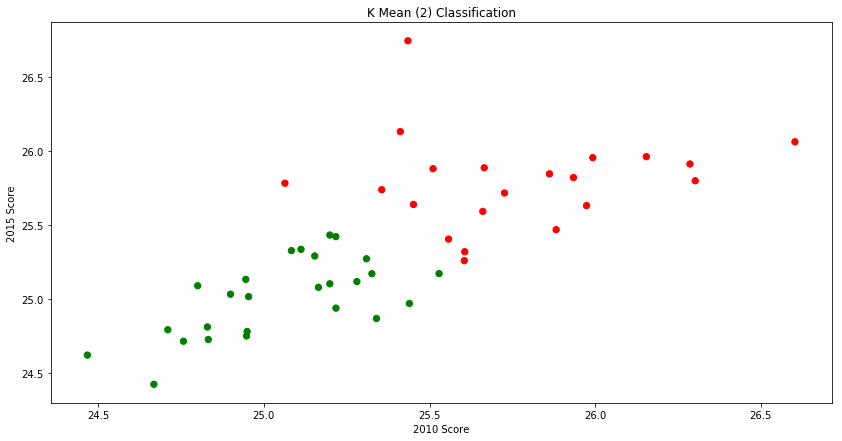

In [85]:
plt.figure(figsize=(14,7))
colormap = np.array(['red', 'green', 'blue', 'orange'])
plt.scatter(k_score[:,0], k_score[:,1], c=colormap[score_cluster.labels_], s=40)
plt.title('K Mean (2) Classification')
plt.xlabel('2010 Score')
plt.ylabel('2015 Score')
plt.show()

Using two clusters appears to just group high vs low score.

In [86]:
#Trying three clusters
score_cluster2 = sklearn.cluster.KMeans(n_clusters=3)
score_cluster2.fit(k_score)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

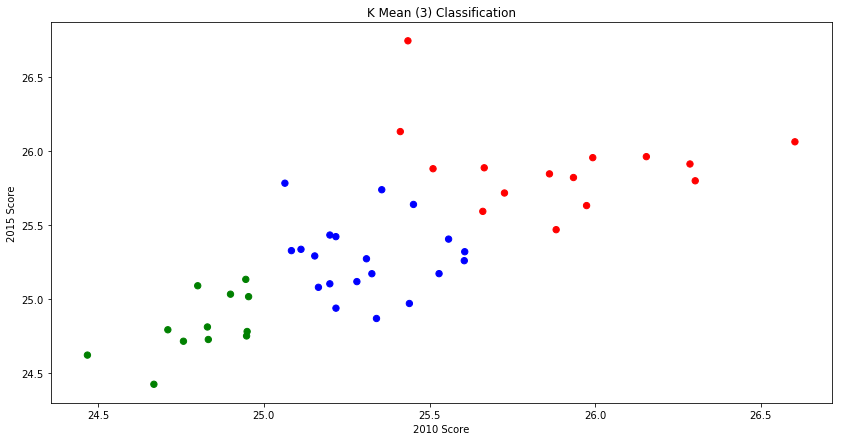

In [87]:
plt.figure(figsize=(14,7))
colormap = np.array(['red', 'green', 'blue', 'orange'])
plt.scatter(k_score[:,0], k_score[:,1], c=colormap[score_cluster2.labels_], s=40)
plt.title('K Mean (3) Classification')
plt.xlabel('2010 Score')
plt.ylabel('2015 Score')
plt.show()

Using three clusters appears to just group high, medium, low score.

In [88]:
#Trying four clusters
score_cluster3 = sklearn.cluster.KMeans(n_clusters=4)
score_cluster3.fit(k_score)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

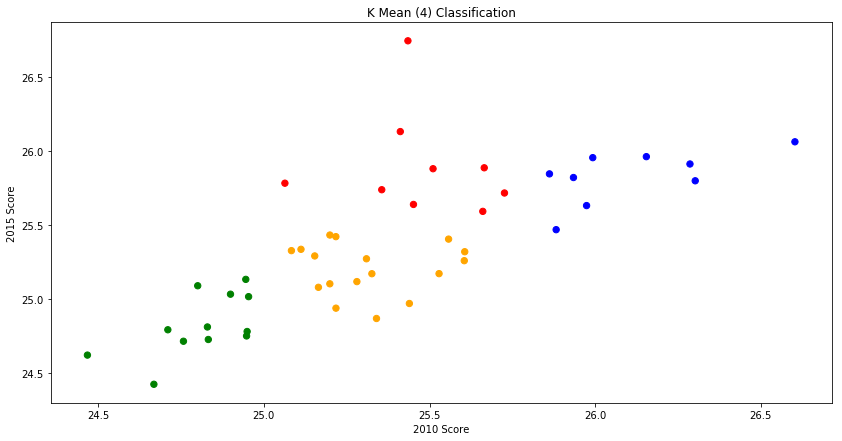

In [89]:
plt.figure(figsize=(14,7))
colormap = np.array(['red', 'green', 'blue', 'orange'])
plt.scatter(k_score[:,0], k_score[:,1], c=colormap[score_cluster3.labels_], s=40)
plt.title('K Mean (4) Classification')
plt.xlabel('2010 Score')
plt.ylabel('2015 Score')
plt.show()

Using four clusters appears to capture a high, medium, and low as well as the outlier. The ourlier, though, is Central Harlem which is very high on the list for areas that are gentrifying. 

### Exploring Furman Center List to Percent Change in Streetscore from 2010-2015

In this section, we plot the percent difference in Streetscore between 2010-2015 against a dummy variable indicating whether the area appears on the Furman Center's list. While this is "cheating" in the sense that we are reading in the actual list of gentrifying neighborhoods, this exploration allows us to see if there is any clustering based on something other than high vs low percent change. 

In [90]:
# Reading in the Furman list
furman_list = pd.read_csv('/projects/ada_pub_3/shared/Dani/data/furman/furman.csv')
furman_list.columns = ['cd','neighborhood','gentrifying']
furman_list.head()

,cd,neighborhood,gentrifying
0,101,Greenwich Village/Financial District,0
1,102,Lower East Side/Chinatown,1
2,103,Chelsea/Clinton/Midtown,0
3,104,Stuyvesant Town/Turtle Bay,0
4,105,Upper West Side,0


In [91]:
# Creating a dataframe with both variables 
furman_k = machine_est.merge(furman_list, left_on='cd',right_on='cd')[['dif','gentrifying']]
furman_k.head()

,dif,gentrifying
0,0.884523,0
1,-0.147824,0
2,2.864152,0
3,1.504265,0
4,0.859225,1


In [92]:
# Starting with two clusters
k_furman = furman_k.values
furman_cluster = sklearn.cluster.KMeans(n_clusters=2)
furman_cluster.fit(k_furman)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

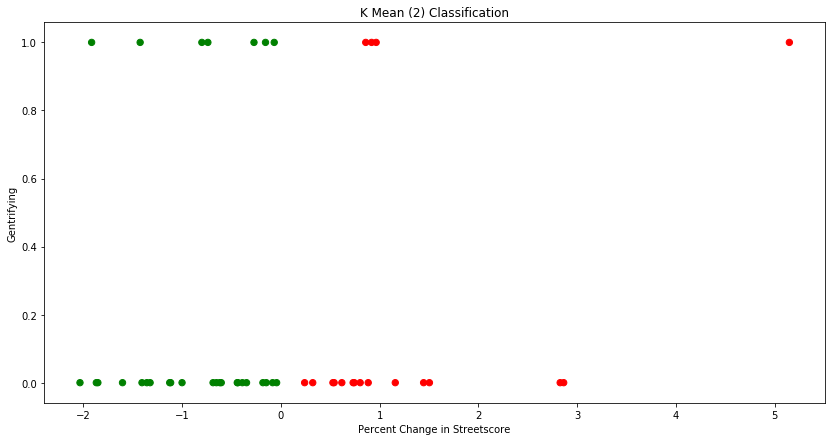

In [93]:
plt.figure(figsize=(14,7))
colormap = np.array(['red', 'green', 'blue', 'orange'])
plt.scatter(k_furman[:,0], k_furman[:,1], c=colormap[furman_cluster.labels_], s=40)
plt.title('K Mean (2) Classification')
plt.xlabel('Percent Change in Streetscore')
plt.ylabel('Gentrifying')
plt.show()

Two clusters provides the (unhelpful) grouping of gentrifying or not. 

In [94]:
#Trying three clusters
furman_cluster2 = sklearn.cluster.KMeans(n_clusters=3)
furman_cluster2.fit(k_furman)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

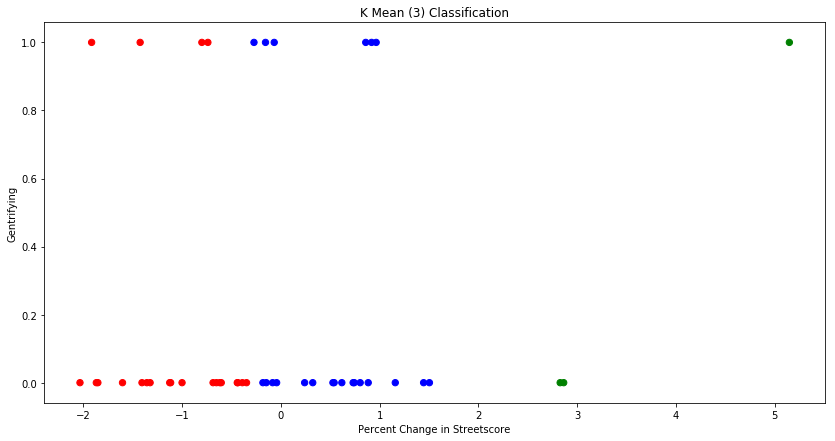

In [95]:
plt.figure(figsize=(14,7))
colormap = np.array(['red', 'green', 'blue', 'orange'])
plt.scatter(k_furman[:,0], k_furman[:,1], c=colormap[furman_cluster2.labels_], s=40)
plt.title('K Mean (3) Classification')
plt.xlabel('Percent Change in Streetscore')
plt.ylabel('Gentrifying')
plt.show()

Three clusters seems to group based on gentrifying, not gentrifying, and areas that look like they should be gentrifying but are not. 

In [96]:
# Trying four clusters
furman_cluster3 = sklearn.cluster.KMeans(n_clusters=4)
furman_cluster3.fit(k_furman)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

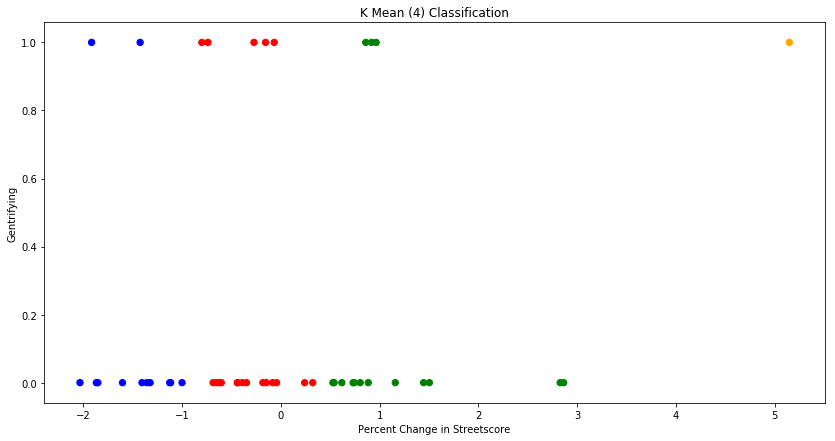

In [97]:
plt.figure(figsize=(14,7))
colormap = np.array(['red', 'green', 'blue', 'orange'])
plt.scatter(k_furman[:,0], k_furman[:,1], c=colormap[furman_cluster3.labels_], s=40)
plt.title('K Mean (4) Classification')
plt.xlabel('Percent Change in Streetscore')
plt.ylabel('Gentrifying')
plt.show()

Based on the run, this either groups based on false/true postive/negative or high/medium-high/medium-low/low percent change.

In [98]:
# Trying four clusters
furman_cluster4 = sklearn.cluster.KMeans(n_clusters=6)
furman_cluster4.fit(k_furman)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

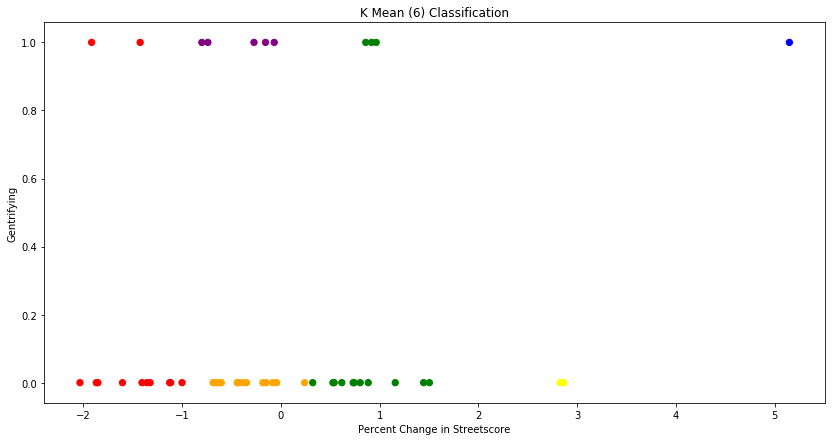

In [99]:
plt.figure(figsize=(14,7))
colormap = np.array(['red', 'green', 'blue', 'orange', 'purple', 'yellow'])
plt.scatter(k_furman[:,0], k_furman[:,1], c=colormap[furman_cluster4.labels_], s=40)
plt.title('K Mean (6) Classification')
plt.xlabel('Percent Change in Streetscore')
plt.ylabel('Gentrifying')
plt.show()

There does not seem to be any useful clustering.

# Just for Fun

Are machines smarter than people? Our assumption is that gentrification will be correlated with a high percentage change in Streetscore. However, as our results show, this method does not take into account areas that are already wealthy and improve significantly. For example, the Upper East Side appeared as a neighborhood that is likely gentrifying. However, this is certainly not the case given our definition of gentrification.  

In this section we use machine learning to see what AI thinks: we input the starting Streetscore (2010), the ending Streetscore (2015), the percent difference between 2010 and 2015, and the average annual difference and compare it to the Furman Center list to generate an algorithm. This algorithm could be used to better identify gentrifying areas.

In [100]:
test_further = machine_est[['cd','2010','2015','dif','avg_dif']]
test_further = test_further.merge(furman_list, left_on='cd',right_on='cd')
test_further.head()

,cd,2010,2015,dif,avg_dif,neighborhood,gentrifying
0,101,25.112158,25.334281,0.884523,0.219370,Greenwich Village/Financial District,0
1,103,25.992696,25.954273,-0.147824,-0.010794,Chelsea/Clinton/Midtown,0
2,104,25.063608,25.781468,2.864152,0.598010,Stuyvesant Town/Turtle Bay,0
3,106,25.355889,25.737309,1.504265,0.326105,Upper East Side,0
4,107,25.665186,25.885708,0.859225,0.200283,Morningside Heights/Hamilton Heights,1


In [101]:
n_train, n_test = train_test_split(test_further, test_size=0.5)

n_features = ['2010','2015','dif','avg_dif']
n_label = 'gentrifying'

X_train_n = n_train[n_features].values
y_train_n = n_train[n_label].values
X_test_n = n_test[n_features].values
y_test_n = n_test[n_label].values

In [102]:
n_model = LinearRegression()
n_model.fit(X_train_n, y_train_n)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [103]:
n_predicted = n_model.predict(X_test_n)
n_predicted

array([-0.06061296,  0.24100587,  0.22555833,  0.43524718, -0.15802402,
       -0.0348581 ,  0.32715465, -0.15980689,  0.12228831, -0.11248884,
        0.21367296,  0.12419933,  0.43936851,  0.00582084,  0.34598371,
       -0.01853843,  0.08116287,  0.4475677 , -0.36264488,  0.73648229,
        0.1580763 , -0.06436912,  0.72726684, -0.07080382])

In [104]:
n_actual = y_test_n
n_actual

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0])

In [105]:
calc_threshold = lambda x,y: 0 if x < y else 1 
n_predicted = np.array( [calc_threshold(score,0.50) for score in n_predicted] )
n_expected = n_actual

In [106]:
conf_matrix = confusion_matrix(n_expected,n_predicted)
print conf_matrix

[[19  1]
 [ 3  1]]


In [107]:
accuracy = accuracy_score(n_expected, n_predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.8333333333333334


In [108]:
precision = precision_score(n_actual, n_predicted)
recall = recall_score(n_actual, n_predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.5
Recall= 0.25


In [109]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.437500


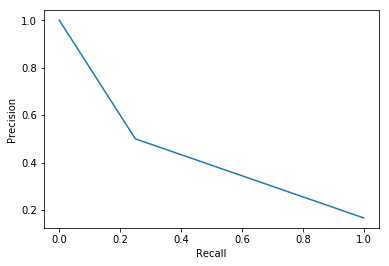

<Figure size 432x288 with 0 Axes>

In [110]:
plot_precision_recall(n_expected, n_predicted)

In [111]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls 
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

In [112]:
def precision_at_k(y_true, y_scores,k):
    
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores ])
    return precision_score(y_true, y_pred)

<Figure size 432x288 with 0 Axes>

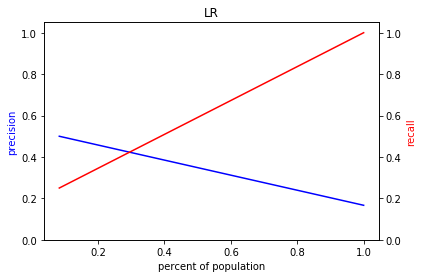

<Figure size 432x288 with 0 Axes>

In [113]:
plot_precision_recall_n(n_expected,n_predicted, 'LR')

In [114]:
p_at_1 = precision_at_k(n_expected,n_predicted, 0.01)
print('Precision at 1%: {:.2f}'.format(p_at_1))

Precision at 1%: 0.50


In [115]:
random_score = [random.uniform(0,1) for i in enumerate(y_test_n)] 
random_predicted = np.array( [calc_threshold(score,0.5) for score in random_score] )
random_p_at_5 = precision_at_k(n_expected,random_predicted, 0.01)
print('Precision at 1% (random): {:.2f}'.format(random_p_at_5))

Precision at 1% (random): 0.09


In [116]:
n_input = test_further[['2010','2015','dif','avg_dif']]

In [117]:
n_output = n_model.predict(n_input)

In [118]:
test_further['estimate'] = n_output
test_further = test_further.sort_values(by=['estimate'], ascending=False)
test_further = test_further.merge(furman_labels,left_on='cd',right_on='cd')

In [119]:
test_further = test_further.drop_duplicates()
test_further[['neighborhoods','estimate','gentrifying']]

,neighborhoods,estimate,gentrifying
0,Central Harlem,0.755643,1
1,Morningside Heights/Hamilton Heights,0.736482,1
2,Chelsea/Clinton/Midtown,0.727267,0
3,South Crown Heights,0.604994,1
4,Bedford Stuyvesant,0.507876,1
5,Upper East Side,0.507737,0
6,Borough Park,0.490466,0
7,Flushing/Whitestone,0.447568,0
8,Hillcrest/Fresh Meadows,0.441330,0
9,Greenwich Village/Financial District,0.439369,0
